# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from itertools import product
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [2]:
# Define a function to load data and aggregate them


def load_and_aggregate_stock_data(folder_path):

    all_files = glob(os.path.join(folder_path, "*.csv"))
    combined_data = []

    for file in all_files:
        # Extract stock name from file name 
        stock_name = os.path.splitext(os.path.basename(file))[0].upper().split('_')[0]

        # Load CSV
        df = pd.read_csv(file)

        # Add stock name column
        df['Stock'] = stock_name

        # Drop redundant 'Name' column if it exists
        if 'Name' in df.columns:
            df.drop(columns=['Name'], inplace=True)

        combined_data.append(df)

    # Combine all data
    aggregated_df = pd.concat(combined_data, ignore_index=True)

    # Convert 'Date' to datetime and sort
    aggregated_df['Date'] = pd.to_datetime(aggregated_df['Date'])
    aggregated_df = aggregated_df.sort_values(by=['Date', 'Stock']).reset_index(drop=True)

    return aggregated_df


In [3]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

folder_path = "./RNN_Stocks_Data"
aggregated_df = load_and_aggregate_stock_data(folder_path)

print(aggregated_df.head())

        Date    Open    High     Low   Close    Volume  Stock
0 2006-01-03   47.47   47.85   46.25   47.58   7582127   AMZN
1 2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
2 2006-01-03   82.45   82.55   80.81   82.06  11715200    IBM
3 2006-01-03   26.25   27.00   26.10   26.84  79974418   MSFT
4 2006-01-04   47.48   47.73   46.69   47.25   7440914   AMZN


In [4]:
# View specifics of the data
print("Shape of DataFrame:", aggregated_df.shape)
print("-"*40)
print("Dataset info:")
print(aggregated_df.info())
print("-"*40)
print("\nMissing values per column:")
print(aggregated_df.isnull().sum())
print("-"*40)
print("\nSummary statistics:")
print(aggregated_df.describe())
print("-"*40)
print("\nDate range:")
print("Start date:", aggregated_df['Date'].min())
print("End date:", aggregated_df['Date'].max())
print("-"*40)
print("\nNumber of records per stock:")
print(aggregated_df['Stock'].value_counts())
print("-"*40)
print("\nRedundant Rows if any:")
print(aggregated_df.duplicated().sum())
print("-"*40)
# Count duplicates by Stock and Date
duplicates = aggregated_df.groupby(['Stock', 'Date']).size().reset_index(name='Count')
duplicates = duplicates[duplicates['Count'] > 1]
print("Duplicate (Stock, Date) entries:")
print(duplicates)

Shape of DataFrame: (12077, 7)
----------------------------------------
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    12077 non-null  datetime64[ns]
 1   Open    12076 non-null  float64       
 2   High    12077 non-null  float64       
 3   Low     12076 non-null  float64       
 4   Close   12077 non-null  float64       
 5   Volume  12077 non-null  int64         
 6   Stock   12077 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 660.6+ KB
None
----------------------------------------

Missing values per column:
Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Stock     0
dtype: int64
----------------------------------------

Summary statistics:
                                Date          Open          High  \
count                     

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [5]:
print("Missing values per column:")
print(aggregated_df.isnull().sum())
print("-"*40)
# Row with the missing values
print("Row(s) will null values: ")
print(aggregated_df[aggregated_df.isnull().any(axis=1)])

# day of the week for the date with missing values
print("Day of the week:", list(aggregated_df[aggregated_df.isnull().any(axis=1)]['Date'])[0].strftime("%A"))
print("-"*40)
# all the entries for the date with missing values
print("All the entries for the date with missing values:")
print(aggregated_df[aggregated_df['Date'].isin(aggregated_df[aggregated_df.isnull().any(axis=1)]['Date'].unique())])
print("-"*40)

Missing values per column:
Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Stock     0
dtype: int64
----------------------------------------
Row(s) will null values: 
            Date  Open    High  Low   Close   Volume Stock
11651 2017-07-31   NaN  144.93  NaN  144.67  4355718   IBM
Day of the week: Monday
----------------------------------------
All the entries for the date with missing values:
            Date     Open     High     Low   Close    Volume  Stock
11649 2017-07-31  1019.05  1019.05  987.02  987.78   7352063   AMZN
11650 2017-07-31   960.00   961.19  941.72  945.50   2293389  GOOGL
11651 2017-07-31      NaN   144.93     NaN  144.67   4355718    IBM
11652 2017-07-31    73.30    73.44   72.41   72.70  23600054   MSFT
----------------------------------------


##### `Observations`
1. There are missing values in two key columns:
   - Open: 1 missing
   - Low: 1 missing
2. The other stock has entries on that day. So, it seems that it might be a data error.

##### `Conclusion`
These entiries for these rows needs to be imputed. We choose to use `linear interpolation` to impute these entries. This method is often a good method for continuous numerical data like stock prices as it attempts to maintain the trend.

In [6]:
print("Before Linear interpolation:")
aggregated_df[(aggregated_df['Date'].isin(['2017-07-31','2017-07-28','2017-08-01','2017-07-27','2017-08-02' ])) & (aggregated_df['Stock'] == 'IBM')]

Before Linear interpolation:


Date    Open    High     Low   Close   Volume Stock
11643 2017-07-27  145.00  145.40  143.64  145.07  6430841   IBM
11647 2017-07-28  144.81  145.04  143.84  144.29  3054834   IBM
11651 2017-07-31     NaN  144.93     NaN  144.67  4355718   IBM
11655 2017-08-01  145.00  145.67  144.72  145.30  3219477   IBM
11659 2017-08-02  145.12  145.29  144.22  144.45  3540949   IBM

In [7]:
# Handle Missing Values

# Filter IBM rows
ibm_data = aggregated_df[aggregated_df['Stock'] == 'IBM']

# Interpolate 'Open' and 'Low' only
aggregated_df.loc[aggregated_df['Stock'] == 'IBM', ['Open', 'Low']] = (
    ibm_data[['Open', 'Low']].interpolate(method='linear', limit_direction='both').round(2)
)

# Confirm that all missing values are handled
print("Missing values after interpolation:")
print(aggregated_df.isnull().sum())


Missing values after interpolation:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Stock     0
dtype: int64


In [8]:
print("After Linear interpolation:")
aggregated_df[(aggregated_df['Date'].isin(['2017-07-31','2017-07-28','2017-08-01','2017-07-27','2017-08-02' ])) & (aggregated_df['Stock'] == 'IBM')]

After Linear interpolation:


Date    Open    High     Low   Close   Volume Stock
11643 2017-07-27  145.00  145.40  143.64  145.07  6430841   IBM
11647 2017-07-28  144.81  145.04  143.84  144.29  3054834   IBM
11651 2017-07-31  144.90  144.93  144.28  144.67  4355718   IBM
11655 2017-08-01  145.00  145.67  144.72  145.30  3219477   IBM
11659 2017-08-02  145.12  145.29  144.22  144.45  3540949   IBM

#### Handling Extra Row in IBM

In [9]:
print("Number of records per stock:")
print(aggregated_df['Stock'].value_counts())
print("-"*40)
# Get the date for which IBM has extra date
# Get the set of dates per stock
stock_dates = aggregated_df.groupby('Stock')['Date'].apply(set)

# Identify extra date in IBM
ibm_extra_dates = stock_dates['IBM'] - (stock_dates['AMZN'] & stock_dates['GOOGL'] & stock_dates['MSFT'])

# View the extra date
print("Extra date(s) in IBM:", ibm_extra_dates)
print("Day of the week:", list(ibm_extra_dates)[0].strftime("%A"))
print("-"*40)
print("Extra IBM Row:")
extra_ibm_row = aggregated_df[(aggregated_df['Stock'] == 'IBM') & (aggregated_df['Date'].isin(ibm_extra_dates))]
print(extra_ibm_row)
print("-"*40)

Number of records per stock:
Stock
IBM      3020
AMZN     3019
GOOGL    3019
MSFT     3019
Name: count, dtype: int64
----------------------------------------
Extra date(s) in IBM: {Timestamp('2010-04-01 00:00:00')}
Day of the week: Thursday
----------------------------------------
Extra IBM Row:
           Date    Open    High     Low   Close   Volume Stock
4272 2010-04-01  128.95  129.31  127.55  128.25  4980625   IBM
----------------------------------------


##### `Observation`
1. There is one row extra for IBM
2. The extra row is for date 2010-04-01. Other stock not having entry on that date.

##### `Conclusion`
RNNs process sequential data assuming each time step is present and aligned across all sequences. So, we should be removing the extra entry for IBM.

In [10]:
aggregated_df = aggregated_df.drop(extra_ibm_row.index)

# Reconfirm record counts
print("\nUpdated record counts per stock:")
print(aggregated_df['Stock'].value_counts())


Updated record counts per stock:
Stock
AMZN     3019
GOOGL    3019
IBM      3019
MSFT     3019
Name: count, dtype: int64


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

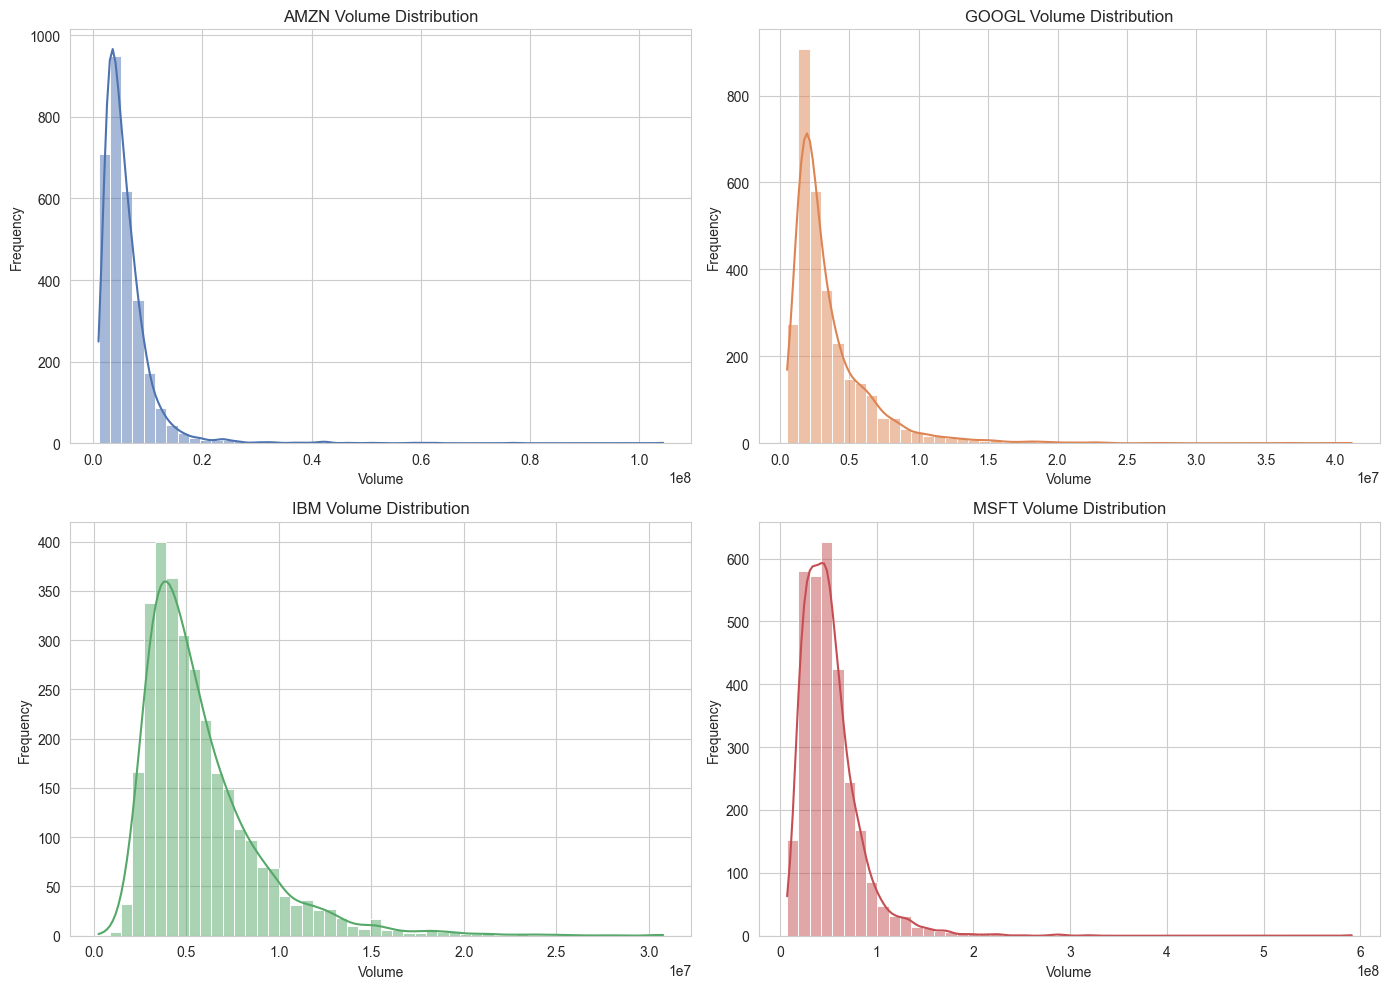

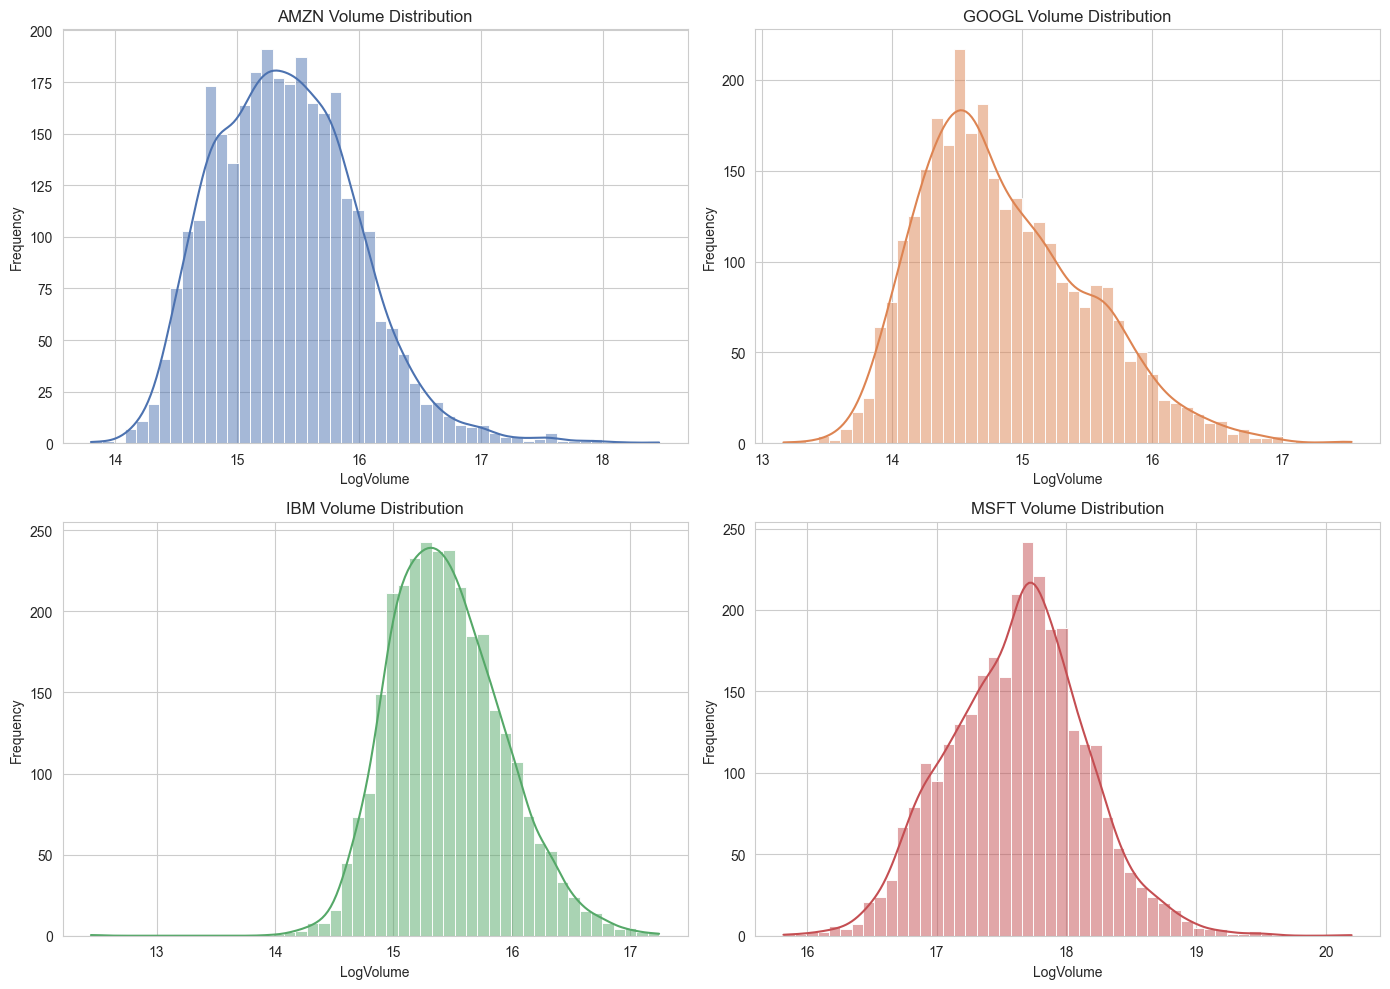

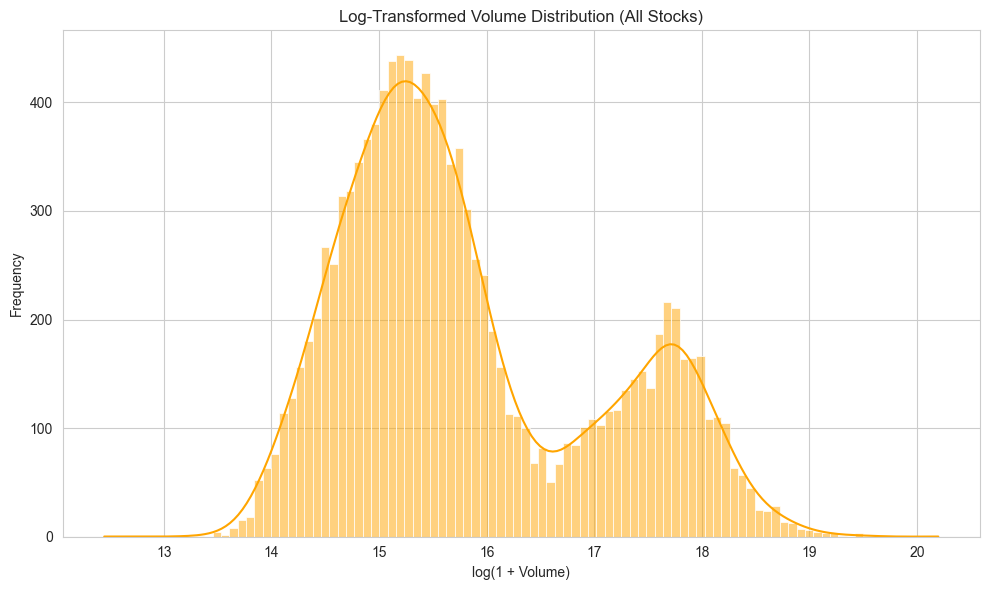

In [11]:
# Frequency distribution of volumes

import numpy as np

sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))

stocks = aggregated_df['Stock'].unique()

for i, stock in enumerate(stocks, 1):
    plt.subplot(2, 2, i)
    sns.histplot(
        data=aggregated_df[aggregated_df['Stock'] == stock],
        x='Volume',
        bins=50,
        kde=True,
        color=sns.color_palette("deep")[i - 1]
    )
    plt.title(f"{stock} Volume Distribution")
    plt.xlabel("Volume")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()
#########################################
plt.figure(figsize=(14, 10))
aggregated_df['LogVolume'] = np.log1p(aggregated_df['Volume'])

for i, stock in enumerate(stocks, 1):
    plt.subplot(2, 2, i)
    sns.histplot(
        data=aggregated_df[aggregated_df['Stock'] == stock],
        x='LogVolume',
        bins=50,
        kde=True,
        color=sns.color_palette("deep")[i - 1]
    )
    plt.title(f"{stock} Volume Distribution")
    plt.xlabel("LogVolume")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()
###########################################
aggregated_df['LogVolume'] = np.log1p(aggregated_df['Volume'])

plt.figure(figsize=(10, 6))
sns.histplot(aggregated_df['LogVolume'], bins=100, kde=True, color='orange')
plt.title("Log-Transformed Volume Distribution (All Stocks)")
plt.xlabel("log(1 + Volume)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# Stock volume variation over time

sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# Plot each stock's volume over time
for stock in aggregated_df['Stock'].unique():
    stock_data = aggregated_df[aggregated_df['Stock'] == stock]
    plt.plot(stock_data['Date'], stock_data['Volume'], label=stock)

plt.title("Stock Volume Variation Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
######################################################

plt.figure(figsize=(14, 6))

# Apply 30-day rolling average to volume
for stock in aggregated_df['Stock'].unique():
    stock_data = aggregated_df[aggregated_df['Stock'] == stock].copy()
    stock_data['Volume_Smooth'] = stock_data['Volume'].rolling(window=30).mean()
    plt.plot(stock_data['Date'], stock_data['Volume_Smooth'], label=stock)

plt.title("30-Day Rolling Average of Volume")
plt.xlabel("Date")
plt.ylabel("Volume (Smoothed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### `Observation`
The stock volume of each of these stocks have decreased over time.

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

Correlation matrix (all stocks):
             Open      High       Low     Close    Volume
Open    1.000000  0.999945  0.999919  0.999873 -0.420743
High    0.999945  1.000000  0.999907  0.999935 -0.421105
Low     0.999919  0.999907  1.000000  0.999945 -0.420675
Close   0.999873  0.999935  0.999945  1.000000 -0.420897
Volume -0.420743 -0.421105 -0.420675 -0.420897  1.000000
------------------------------------------------------------


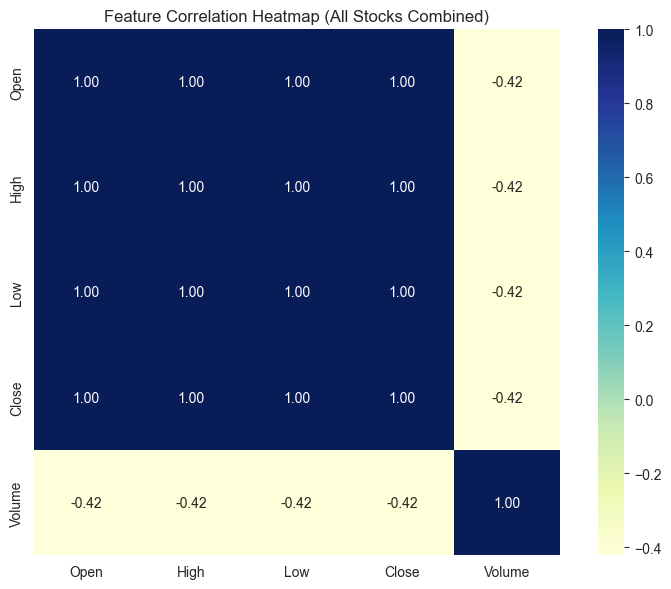

In [13]:
# Analyse correlations

numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
correlation_matrix = aggregated_df[numeric_cols].corr()
print("Correlation matrix (all stocks):\n", correlation_matrix)
print("-"*60)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt=".2f", square=True)
plt.title("Feature Correlation Heatmap (All Stocks Combined)")
plt.tight_layout()
plt.show()


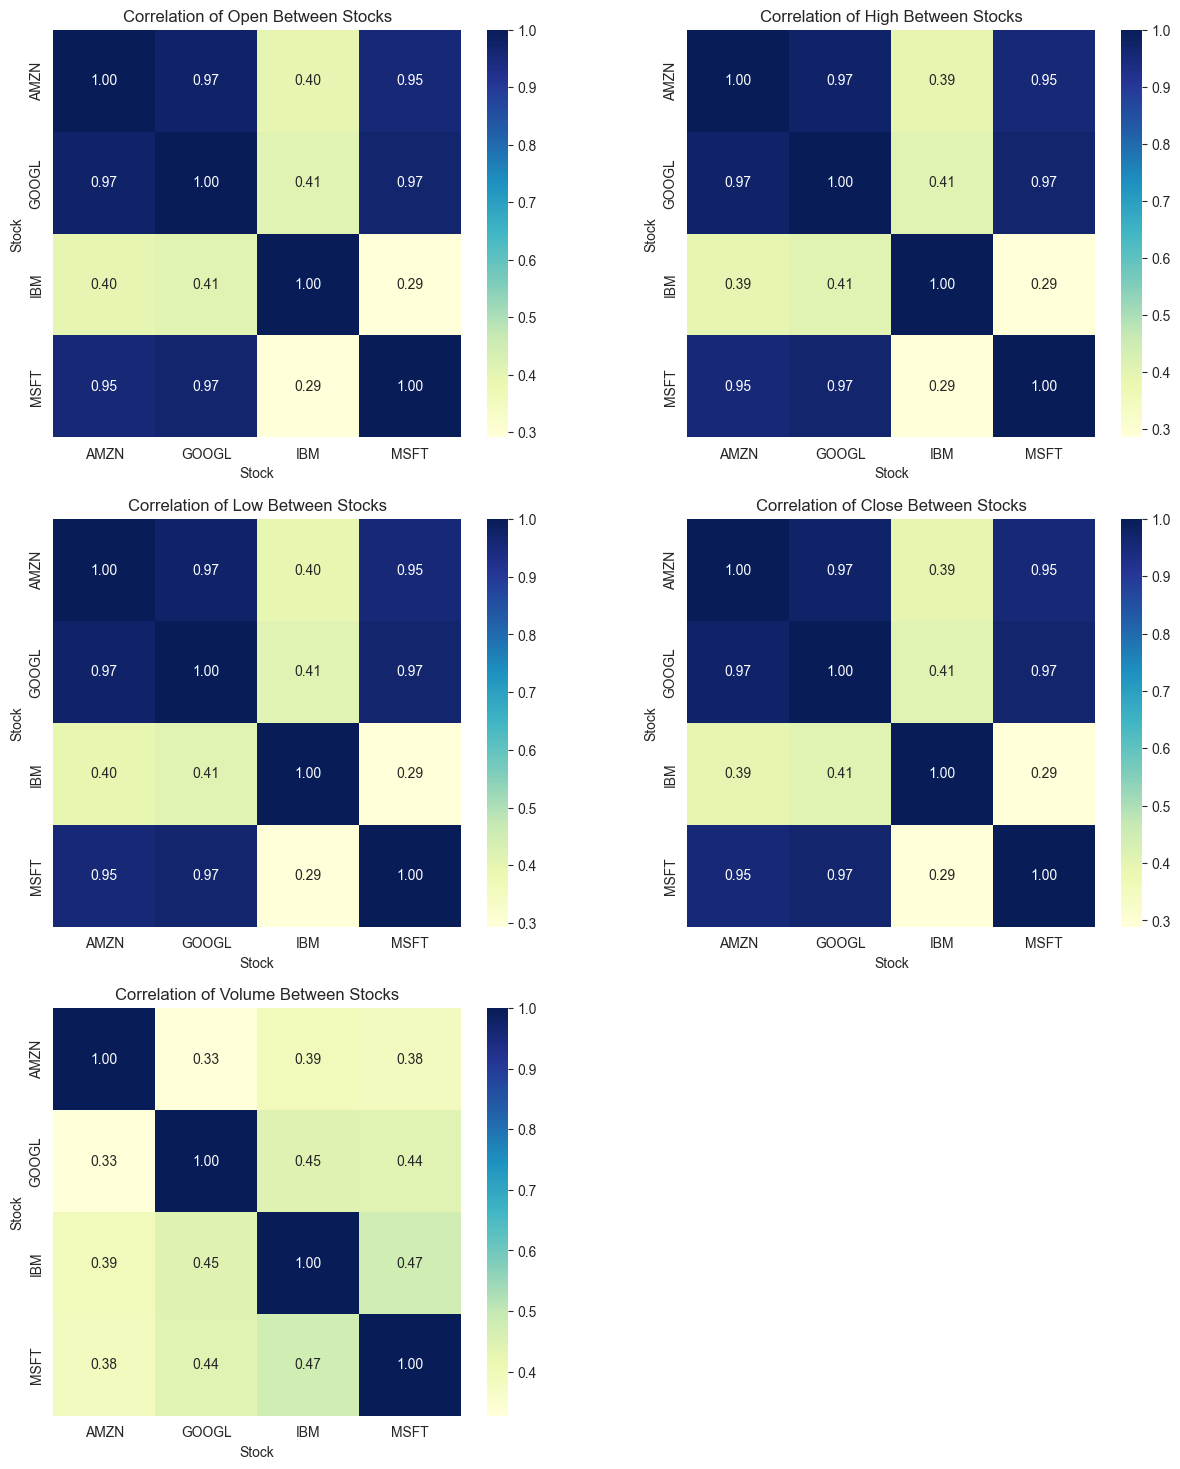

In [14]:
# Correlation of various features between stocks
plt.figure(figsize=(15, math.ceil(len(list(numeric_cols))/2)*6))
#plt.title("Correlation of various features between Stocks")
position=1
for col in numeric_cols:
    pvt = aggregated_df.pivot(index='Date', columns='Stock', values=col)
    corr = pvt.corr()
    #print("Correlation of ", col, " prices between stocks:\n", corr)
    plt.subplot(math.ceil(len(list(numeric_cols))/2),2,position)
    sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt=".2f", square=True)
    plt.title("Correlation of "+ col + " Between Stocks")
    position = position+1
    

##### `Observation`

- MSFT, GOOGL, AMZN has very high correlation for Open, High, Low and Close prices
- IBM has less correlation with the other three for Open, High, Low and Close prices
- High correlation is also not observerd among the stocks for Volume

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [15]:
# Define a function that divides the data into windows and generates target variable values for each window

def generate_windowed_data(df, window_size=3, step_size=1, target_stocks=['AMZN']):

    X = []
    y = []

    # Pivot data so each stock's Close is a column
    close_df = df.pivot(index='Date', columns='Stock', values='Close')
    feature_df = df.pivot(index='Date', columns='Stock')[['Open', 'High', 'Low', 'Close', 'Volume']]
    #print(close_df)
    #print(feature_df)

    # Flatten multi-index for features
    feature_df.columns = [f"{var}_{stock}" for var, stock in feature_df.columns]

    # Ensure time order
    feature_df = feature_df.sort_index()
    close_df = close_df.sort_index()

    for i in range(0, len(feature_df) - window_size, step_size):
        # Windowed input data
        window = feature_df.iloc[i: i + window_size].values
        X.append(window)

        target_close = close_df.iloc[i + window_size][target_stocks].values
        y.append(target_close if len(target_stocks) > 1 else target_close[0])

    return np.array(X), np.array(y)


##### `Explaination`

This function aggregates all the data of all four stocks in a single row and forms `X`. So `X` will have 4X5 = 20 features other than the date. The `y` will have all the target variable (Close price) of the stock(s).

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [16]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X, y):

    n_samples, window_size, n_features = X.shape
    X_reshaped = X.reshape(n_samples * window_size, n_features)

    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    
    # Use partial_fit on the full reshaped X
    x_scaler.partial_fit(X_reshaped)
    X_scaled = x_scaler.transform(X_reshaped).reshape(n_samples, window_size, n_features)

    # Ensure y is 2D
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    y_scaler.partial_fit(y)
    y_scaled = y_scaler.transform(y)

    return X_scaled, y_scaled, x_scaler, y_scaler


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [17]:
# Define a function to create input and output data points from the master DataFrame

def generate_train_test_data(
    df,
    target_stocks=['AMZN'],
    window_size=3,
    step_size=1,
    test_ratio=0.3
):

    # Create windowed features and target
    X, y = generate_windowed_data(
        df,
        window_size=window_size,
        step_size=step_size,
        target_stocks=target_stocks
    )

    # perform scaling
    X_scaled, y_scaled, x_scaler, y_scaler = scale_windowed_data(X, y)

    # Train test split
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y_scaled, test_size=test_ratio, shuffle=False
    )

    return X_train, y_train, X_val, y_val, x_scaler, y_scaler


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

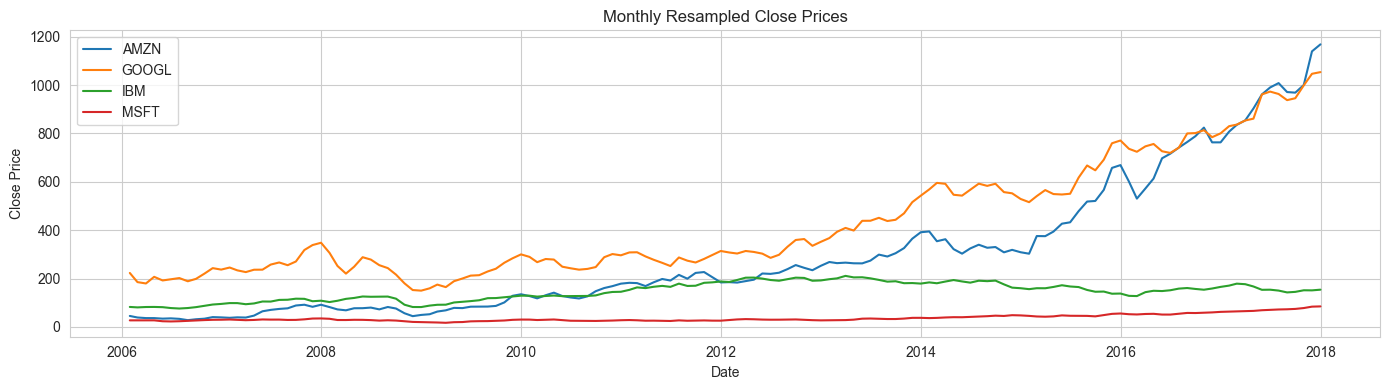

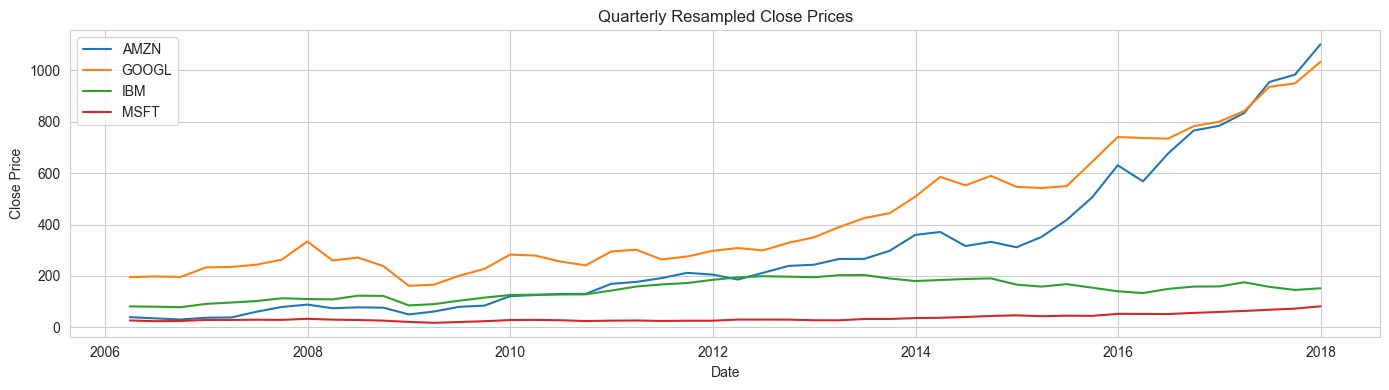

In [18]:
# Checking for patterns in different sequence lengths

def plot_resampled_close_prices(df):

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    stocks = df['Stock'].unique()
    frequencies = {'W': 'Weekly', 'M': 'Monthly', 'Q': 'Quarterly'}

    for freq_code, freq_name in frequencies.items():
        plt.figure(figsize=(14, 4))
        for stock in stocks:
            stock_df = df[df['Stock'] == stock].copy()
            stock_df.set_index('Date', inplace=True)
            resampled = stock_df['Close'].resample(freq_code).mean()
            plt.plot(resampled.index, resampled.values, label=stock)
        plt.title(f'{freq_name} Resampled Close Prices')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
plot_resampled_close_prices(aggregated_df)



##### `Explaination`

It seems that Monthly window will give the best result for us. 
We have tried weekly and quaterly as well but monthly gave the best result. So, we are taking the window size to be 21.

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

##### Note: We are choosing IBM. We will be predicting the close price of IBM.

In [19]:
# Create data instances from the master data frame using decided window size and window stride
window_size = 21
step_size = 1
test_ratio = 0.3
#target_stocks = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
target_stocks = ['IBM']

X_train, y_train, X_test, y_test, x_scaler, y_scaler = generate_train_test_data(
    aggregated_df,
    target_stocks=target_stocks,
    window_size=window_size,
    step_size=step_size,
    test_ratio=test_ratio
)

In [20]:
# Check the number of data points generated
print("Total data points:", len(X_train) + len(X_test))
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Total data points: 2998
Training samples: 2098
Testing samples: 900


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [21]:
# Check if the datasets are compatible inputs to neural networks

print("Data Shape Check:")
print("-"*30)
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape  : {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape  : {y_test.shape}")


Data Shape Check:
------------------------------
X_train shape: (2098, 21, 20)
X_val shape  : (900, 21, 20)
y_train shape: (2098, 1)
y_val shape  : (900, 1)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [22]:
# Create a function that creates a simple RNN model according to the model configuration arguments


def create_simple_rnn_model(input_shape, rnn_units=64, dense_units=32, dropout_rate=0.2, 
                            output_dim=1, learning_rate=0.001):

    model = Sequential()
    
    model.add(SimpleRNN(units=rnn_units, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(output_dim, activation='linear')) 
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    return model


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [23]:
# Find an optimal configuration of simple RNN

# Here we define a function to create and train RNN with different hyperparameter combinations 
# and find the validation loss for each combination

def run_rnn_hyperparameter_tuning(X_train, y_train, X_val, y_val, input_shape, param_grid):
    results = []

    # Create all combinations
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for i, combo in enumerate(all_combinations):
        config = dict(zip(param_names, combo))
        print(f"Running {i+1}/{len(all_combinations)}: {config}")

        model = create_simple_rnn_model(
            input_shape=input_shape,
            rnn_units=config['rnn_units'],
            dense_units=config['dense_units'],
            dropout_rate=config['dropout_rate'],
            learning_rate=config['learning_rate'],
            output_dim=y_train.shape[1]  # 1 if single stock, 4 if all stocks
        )

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=config['epochs'],
            batch_size=config['batch_size'],
            verbose=0,
            callbacks=[early_stop]
        )

        val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
        config['val_loss'] = val_loss
        config['val_mae'] = val_mae
        results.append(config)

        print(f"val_loss: {val_loss:.4f}, val_mae: {val_mae:.4f}\n")

    return pd.DataFrame(results).sort_values(by='val_loss')



##### `Explaination`

The above function create and train RNN with different hyperparameter combinations and find the validation loss for each combination. This helps us find the optimal hyperparameter combination.

In [24]:
# Find an optimal configuration of simple RNN

param_grid = {
    'rnn_units': [32, 64],
    'dense_units': [16, 32, 64],
    'dropout_rate': [ 0.3, 0.5],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32],
    'epochs': [30]
}

input_shape = X_train.shape[1:]  # (timesteps, features)
results_df = run_rnn_hyperparameter_tuning(X_train, y_train, X_test, y_test, input_shape, param_grid)

Running 1/24: {'rnn_units': 32, 'dense_units': 16, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}
val_loss: 0.1617, val_mae: 0.3389

Running 2/24: {'rnn_units': 32, 'dense_units': 16, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0389, val_mae: 0.1596

Running 3/24: {'rnn_units': 32, 'dense_units': 16, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0211, val_mae: 0.1111

Running 4/24: {'rnn_units': 32, 'dense_units': 16, 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0192, val_mae: 0.1016

Running 5/24: {'rnn_units': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0146, val_mae: 0.0993

Running 6/24: {'rnn_units': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 30}
val_loss: 0.3131, val_mae: 0.4494

Running 7/24: {'rnn

In [25]:
# Find the best configuration based on evaluation metrics

print("Top Configurations:")
print(results_df.head())
print("-"*50)


best_config=results_df.iloc[0]
print("Best Configuration:")
print(best_config)

Top Configurations:
    rnn_units  dense_units  dropout_rate  learning_rate  batch_size  epochs  \
10         32           64           0.5         0.0010          32      30   
6          32           32           0.5         0.0010          32      30   
4          32           32           0.3         0.0010          32      30   
21         64           64           0.3         0.0005          32      30   
3          32           16           0.5         0.0005          32      30   

    val_loss   val_mae  
10  0.012794  0.087280  
6   0.013788  0.089219  
4   0.014648  0.099276  
21  0.018411  0.110372  
3   0.019154  0.101583  
--------------------------------------------------
Best Configuration:
rnn_units        32.000000
dense_units      64.000000
dropout_rate      0.500000
learning_rate     0.001000
batch_size       32.000000
epochs           30.000000
val_loss          0.012794
val_mae           0.087280
Name: 10, dtype: float64


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [27]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

#best_config=results_df.iloc[0]

final_model = create_simple_rnn_model(
    input_shape=input_shape,
    rnn_units=int(best_config['rnn_units']),
    dense_units=int(best_config['dense_units']),
    dropout_rate=float(best_config['dropout_rate']),
    learning_rate=float(best_config['learning_rate']),
    output_dim=y_train.shape[1]  
)

final_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=int(best_config['epochs']),
    batch_size=int(best_config['batch_size']),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

train_loss, train_mae = final_model.evaluate(X_train, y_train, verbose=0)
val_loss, val_mae = final_model.evaluate(X_test, y_test, verbose=0)

print("-"*50)
print("Final Model Performance:")
print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"Val   Loss: {val_loss:.4f}, Val   MAE: {val_mae:.4f}")

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_25 (SimpleRNN)       │ (None, 32)             │         1,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,873 (15.13 KB)

 Trainable params: 3,873 (15.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4818 - mae: 0.5416 - val_loss: 0.0341 - val_mae: 0.1380 - learning_rate: 0.0010
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1787 - mae: 0.3322 - val_loss: 0.0214 - val_mae: 0.1122 - learning_rate: 0.0010
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1264 - mae: 0.2831 - val_loss: 0.0247 - val_mae: 0.1320 - learning_rate: 0.0010
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1029 - mae: 0.2518 - val_loss: 0.0203 - val_mae: 0.1114 - learning_rate: 0.0010
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0923 - mae: 0.2361 - val_loss: 0.0454 - val_mae: 0.1834 - learning_rate: 0.0010
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0847 - mae: 0.2274 - val_loss: 0.0389 - val_mae: 0.1723 - learning_rate: 0.0010
Epoch 7/30
56/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0789 - mae: 0.2180 
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
66/6

Plotting the actual vs predicted values

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


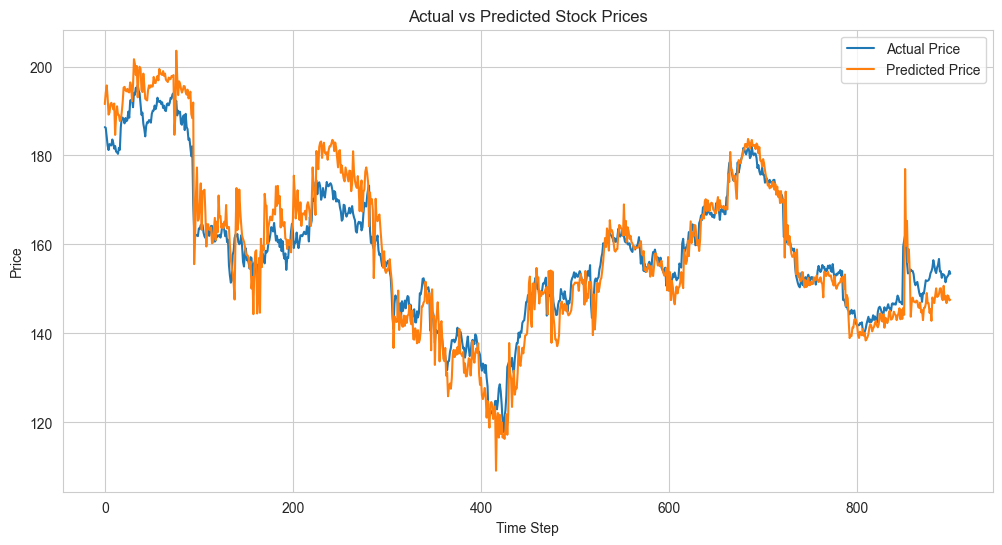

In [28]:

y_pred = final_model.predict(X_test)

y_test_inv = y_scaler.inverse_transform(y_test)
y_pred_inv = y_scaler.inverse_transform(y_pred)

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(y_pred_inv, label='Predicted Price')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [29]:
# Compute the performance of the model on the testing data set

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")


MSE: 0.02 | MAE: 0.11 | R²: 0.8793


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [30]:
# # Define a function to create a model and specify default values for hyperparameters


def create_lstm_model(input_shape,
                      lstm_units=64,
                      dense_units=32,
                      dropout_rate=0.2,
                      learning_rate=0.001,
                      output_dim=1):

    model = Sequential()

    # LSTM layer
    model.add(LSTM(units=lstm_units, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(units=output_dim, activation='linear'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    return model


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [31]:
# Find an optimal configuration

# Here we define a function to create and train LSTM with different hyperparameter combinations 
# and find the validation loss for each combination

def run_lstm_hyperparameter_tuning(X_train, y_train, X_val, y_val, input_shape, param_grid):
    results = []

    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())
    
    for i, combo in enumerate(all_combinations):
        config = dict(zip(param_names, combo))
        print(f"Running {i+1}/{len(all_combinations)}: {config}")

        model = create_lstm_model(
            input_shape=input_shape,
            lstm_units=config['lstm_units'],
            dense_units=config['dense_units'],
            dropout_rate=config['dropout_rate'],
            learning_rate=config['learning_rate'],
            output_dim=y_train.shape[1]
        )

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=config['epochs'],
            batch_size=config['batch_size'],
            verbose=0,
            callbacks=[early_stop]
        )

        train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
        val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)

        config['train_loss'] = train_loss
        config['train_mae'] = train_mae
        config['val_loss'] = val_loss
        config['val_mae'] = val_mae

        results.append(config)

        print(f"val_loss: {val_loss:.4f}, val_mae: {val_mae:.4f}\n")

    return pd.DataFrame(results).sort_values(by='val_loss')



param_grid_lstm = {
    'lstm_units': [32, 64, 128],
    'dense_units': [32, 64],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32],
    'epochs': [30]
}


input_shape = X_train.shape[1:]  # (timesteps, features)
lstm_results_df = run_lstm_hyperparameter_tuning(X_train, y_train, X_test, y_test, input_shape, param_grid_lstm)


Running 1/36: {'lstm_units': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0221, val_mae: 0.1168

Running 2/36: {'lstm_units': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 30}
val_loss: 0.4944, val_mae: 0.5839

Running 3/36: {'lstm_units': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0196, val_mae: 0.1050

Running 4/36: {'lstm_units': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0131, val_mae: 0.0919

Running 5/36: {'lstm_units': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0231, val_mae: 0.1164

Running 6/36: {'lstm_units': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0089, val_mae: 0.0720

Running 7/36:

In [33]:
# Find an optimal configuration
print("Top Configurations:")
print(lstm_results_df.head())
print("-"*50)

best_lstm_config = lstm_results_df.iloc[0]
print("Best LSTM Configuration:")
print(best_lstm_config)

Top Configurations:
    lstm_units  dense_units  dropout_rate  learning_rate  batch_size  epochs  \
35         128           64           0.3         0.0005          32      30   
5           32           32           0.3         0.0005          32      30   
17          64           32           0.3         0.0005          32      30   
11          32           64           0.3         0.0005          32      30   
28         128           32           0.3         0.0010          32      30   

    train_loss  train_mae  val_loss   val_mae  
35    0.006015   0.060897  0.007577  0.065089  
5     0.016727   0.103333  0.008897  0.071978  
17    0.007723   0.069825  0.009672  0.074374  
11    0.016785   0.104248  0.009686  0.075862  
28    0.011887   0.086823  0.009773  0.075155  
--------------------------------------------------
Best LSTM Configuration:
lstm_units       128.000000
dense_units       64.000000
dropout_rate       0.300000
learning_rate      0.000500
batch_size        32.00

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [45]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

final_lstm_model = create_lstm_model(
    input_shape=input_shape,
    lstm_units=int(best_lstm_config['lstm_units']),
    dense_units=int(best_lstm_config['dense_units']),
    dropout_rate=float(best_lstm_config['dropout_rate']),
    learning_rate=float(best_lstm_config['learning_rate']),
    output_dim=y_train.shape[1]
)

final_lstm_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = final_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=int(best_lstm_config['epochs']),
    batch_size=int(best_lstm_config['batch_size']),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

train_loss, train_mae = final_lstm_model.evaluate(X_train, y_train, verbose=0)
val_loss, val_mae = final_lstm_model.evaluate(X_test, y_test, verbose=0)

print("-"*50)
print("Final Model Performance:")
print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"Val   Loss: {val_loss:.4f}, Val   MAE: {val_mae:.4f}")

Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                  │ (None, 128)            │        76,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,609 (330.50 KB)

 Trainable params: 84,609 (330.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3797 - mae: 0.4422 - val_loss: 0.1248 - val_mae: 0.2724 - learning_rate: 5.0000e-04
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0303 - mae: 0.1342 - val_loss: 0.1494 - val_mae: 0.3019 - learning_rate: 5.0000e-04
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0261 - mae: 0.1248 - val_loss: 0.1445 - val_mae: 0.2944 - learning_rate: 5.0000e-04
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0219 - mae: 0.1163 - val_loss: 0.1149 - val_mae: 0.2631 - learning_rate: 5.0000e-04
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0182 - mae: 0.1030 - val_loss: 0.0949 - val_mae: 0.2372 - learning_rate: 5.0000e-04
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0177 - mae: 0.1040 - val_loss: 0.1162 - val_mae: 0.2719 - learning_rate: 5.0000e-04
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0166 - mae: 0.1009 - val_loss: 0.1372 - val_mae: 0.3078 - learning_ra

In [46]:
# Compute the performance of the model on the testing data set

y_pred_LSTM = final_lstm_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_LSTM)
mae = mean_absolute_error(y_test, y_pred_LSTM)
r2 = r2_score(y_test, y_pred_LSTM)

print(f"MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
MSE: 0.01 | MAE: 0.07 | R²: 0.9531


Plotting the actual vs predicted values

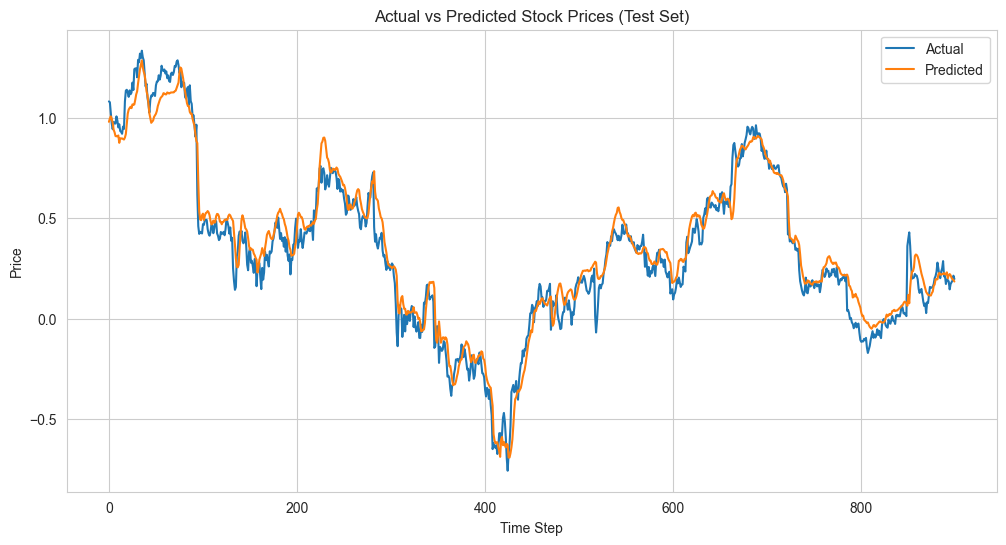

In [47]:
# Predict on the test data

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_LSTM, label='Predicted')
plt.title('Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [48]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter

window_size = 65
step_size = 5
test_ratio = 0.2
target_stocks = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
#target_stocks = ['IBM']

X_train_mul, y_train_mul, X_test_mul, y_test_mul, x_scaler_mul, y_scaler_mul = generate_train_test_data(
    aggregated_df,
    target_stocks=target_stocks,
    window_size=window_size,
    step_size=step_size,
    test_ratio=test_ratio
)

In [49]:
# Check the number of data points generated

print("Total data points:", len(X_train_mul) + len(X_test_mul))
print("Training samples:", len(X_train_mul))
print("Testing samples:", len(X_test_mul))
print("-"*30)

print("\nData Shape Check:")
print(f"X_train shape: {X_train_mul.shape}")
print(f"X_val shape  : {X_test_mul.shape}")
print(f"y_train shape: {y_train_mul.shape}")
print(f"y_val shape  : {y_test_mul.shape}")

Total data points: 591
Training samples: 472
Testing samples: 119
------------------------------

Data Shape Check:
X_train shape: (472, 65, 20)
X_val shape  : (119, 65, 20)
y_train shape: (472, 4)
y_val shape  : (119, 4)


### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [136]:
# Find an optimal configuration of simple RNN

param_grid_mul = {
    'rnn_units': [256, 512],
    'dense_units': [256, 512],
    'dropout_rate': [ 0.3, 0.4, 0.5],
    'learning_rate': [0.002, 0.001],
    'batch_size': [32],
    'epochs': [30]
}

input_shape_mul = X_train_mul.shape[1:]  # (timesteps, features)
results_df_mul = run_rnn_hyperparameter_tuning(X_train_mul, y_train_mul, X_test_mul, y_test_mul, 
                                               input_shape_mul, param_grid_mul)



Running 1/24: {'rnn_units': 256, 'dense_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.002, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0966, val_mae: 0.2195

Running 2/24: {'rnn_units': 256, 'dense_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0764, val_mae: 0.1802

Running 3/24: {'rnn_units': 256, 'dense_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.002, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0822, val_mae: 0.1943

Running 4/24: {'rnn_units': 256, 'dense_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0672, val_mae: 0.1936

Running 5/24: {'rnn_units': 256, 'dense_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.002, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0424, val_mae: 0.1448

Running 6/24: {'rnn_units': 256, 'dense_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}
val_loss: 0.1235, val_mae: 0.2471

Running 7/

In [138]:
# Find the best configuration
print("Top Configurations:")
print(results_df_mul.head())
print("-"*50)

best_config_mul=results_df_mul.iloc[0]
print("Best Configuration:")
print(best_config_mul)


Top Configurations:
    rnn_units  dense_units  dropout_rate  learning_rate  batch_size  epochs  \
17        512          256           0.5          0.001          32      30   
21        512          512           0.4          0.001          32      30   
4         256          256           0.5          0.002          32      30   
13        512          256           0.3          0.001          32      30   
10        256          512           0.5          0.002          32      30   

    val_loss   val_mae  
17  0.025500  0.126147  
21  0.032416  0.128642  
4   0.042383  0.144839  
13  0.044773  0.168988  
10  0.053785  0.169349  
--------------------------------------------------
Best Configuration:
rnn_units        512.000000
dense_units      256.000000
dropout_rate       0.500000
learning_rate      0.001000
batch_size        32.000000
epochs            30.000000
val_loss           0.025500
val_mae            0.126147
Name: 17, dtype: float64


In [147]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the

final_model_mul = create_simple_rnn_model(
    input_shape=input_shape_mul,
    rnn_units=int(best_config_mul['rnn_units']),
    dense_units=int(best_config_mul['dense_units']),
    dropout_rate=float(best_config_mul['dropout_rate']),
    learning_rate=float(best_config_mul['learning_rate']),
    output_dim=y_train_mul.shape[1]  # 1 for single stock, 4 for all stocks
)

final_model_mul.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = final_model_mul.fit(
    X_train_mul, y_train_mul,
    validation_data=(X_test_mul, y_test_mul),
    epochs=int(best_config['epochs']),
    batch_size=int(best_config['batch_size']),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

train_loss, train_mae = final_model_mul.evaluate(X_train_mul, y_train_mul, verbose=0)
val_loss, val_mae = final_model_mul.evaluate(X_test_mul, y_test_mul, verbose=0)

print("-"*50)
print("Final Model Performance:")
print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"Val   Loss: {val_loss:.4f}, Val   MAE: {val_mae:.4f}")

Model: "sequential_331"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_288 (SimpleRNN)      │ (None, 512)            │       272,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_331 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_662 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_663 (Dense)               │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,252 (1.55 MB)

 Trainable params: 405,252 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.4891 - mae: 0.5298 - val_loss: 0.6029 - val_mae: 0.6080 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.1480 - mae: 0.3031 - val_loss: 0.1386 - val_mae: 0.2776 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0963 - mae: 0.2481 - val_loss: 0.1712 - val_mae: 0.3515 - learning_rate: 0.0010
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0774 - mae: 0.2203 - val_loss: 0.2427 - val_mae: 0.3791 - learning_rate: 0.0010
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0684 - mae: 0.2080 - val_loss: 0.1260 - val_mae: 0.2916 - learning_rate: 0.0010
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0540 - mae: 0.1832 - val_loss: 0.0658 - val_mae: 0.1846 - learning_rate: 0.0010
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0521 - mae: 0.1761 - val_loss: 0.1139 - val_mae: 0.2796 - learning_rate: 0.0010
Epoch 8/30

In [148]:
# Compute the performance of the model on the testing data set

y_pred_mul = final_model_mul.predict(X_test_mul)
mse = mean_squared_error(y_test_mul, y_pred_mul)
mae = mean_absolute_error(y_test_mul, y_pred_mul)
r2 = r2_score(y_test_mul, y_pred_mul)

print(f"MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
MSE: 0.03 | MAE: 0.14 | R²: 0.8787


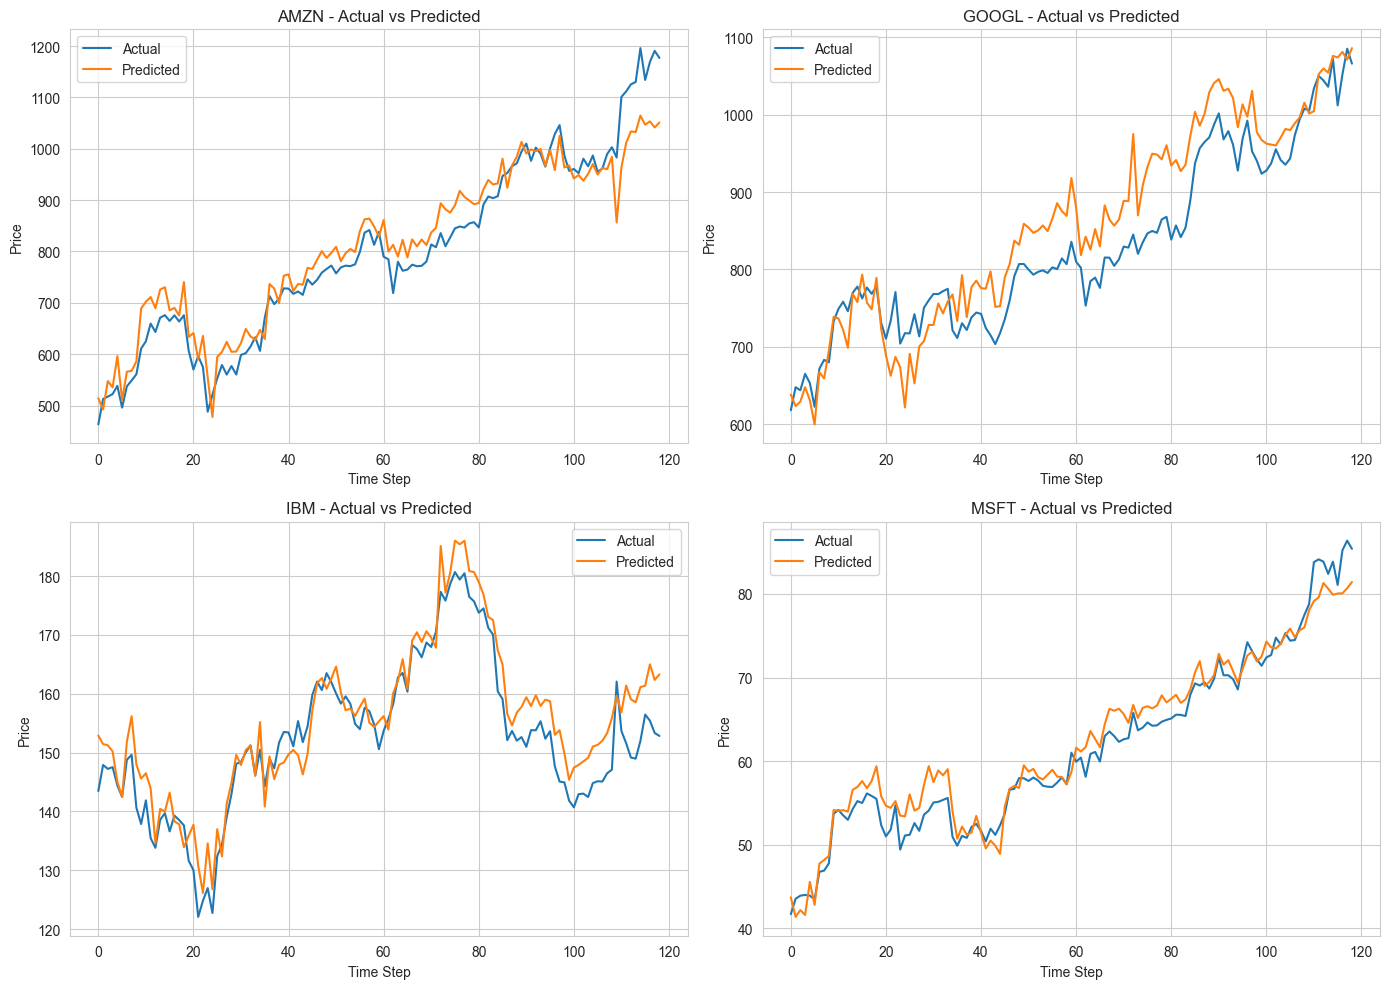

In [149]:
# Plotting the actual vs predicted values for all targets


stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
y_test_mul_inv = y_scaler_mul.inverse_transform(y_test_mul)
y_pred_mul_inv = y_scaler_mul.inverse_transform(y_pred_mul)

plt.figure(figsize=(14, 10))

for i in range(y_test_mul.shape[1]):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test_mul_inv[:, i], label='Actual')
    plt.plot(y_pred_mul_inv[:, i], label='Predicted')
    plt.title(f'{stock_names[i]} - Actual vs Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [150]:
# Find an optimal configuration of advanced RNN

# Find an optimal configuration

param_grid_lstm_mul = {
    'lstm_units': [256, 512],
    'dense_units': [128, 256, 512],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.002],
    'batch_size': [32],
    'epochs': [30]
}



input_shape_mul = X_train_mul.shape[1:]  # (timesteps, features)
lstm_results_df_mul = run_lstm_hyperparameter_tuning(X_train_mul, y_train_mul, X_test_mul, 
                                                     y_test_mul, input_shape_mul, param_grid_lstm_mul)



Running 1/36: {'lstm_units': 256, 'dense_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0321, val_mae: 0.1285

Running 2/36: {'lstm_units': 256, 'dense_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.002, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0361, val_mae: 0.1252

Running 3/36: {'lstm_units': 256, 'dense_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0489, val_mae: 0.1535

Running 4/36: {'lstm_units': 256, 'dense_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.002, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0197, val_mae: 0.1082

Running 5/36: {'lstm_units': 256, 'dense_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0492, val_mae: 0.1500

Running 6/36: {'lstm_units': 256, 'dense_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.002, 'batch_size': 32, 'epochs': 30}
val_loss: 0.0226, val_mae: 0.1055

Runn

In [151]:
# Find the best configuration

print("Top Configurations:")
print(lstm_results_df_mul.head())
print("-"*50)

best_lstm_config_mul = lstm_results_df_mul.iloc[2]
print("Best LSTM Configuration:")
print(best_lstm_config_mul)

Top Configurations:
    lstm_units  dense_units  dropout_rate  learning_rate  batch_size  epochs  \
19         512          128           0.1          0.002          32      30   
31         512          512           0.1          0.002          32      30   
20         512          128           0.2          0.001          32      30   
18         512          128           0.1          0.001          32      30   
29         512          256           0.3          0.002          32      30   

    train_loss  train_mae  val_loss   val_mae  
19    0.002170   0.035746  0.010355  0.078531  
31    0.002425   0.036639  0.010644  0.075246  
20    0.003626   0.045931  0.014356  0.093735  
18    0.002372   0.034996  0.015755  0.095980  
29    0.005633   0.057461  0.015925  0.095861  
--------------------------------------------------
Best LSTM Configuration:
lstm_units       512.000000
dense_units      128.000000
dropout_rate       0.200000
learning_rate      0.001000
batch_size        32.00

In [152]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model

final_lstm_model_mul = create_lstm_model(
    input_shape=input_shape_mul,
    lstm_units=int(best_lstm_config_mul['lstm_units']),
    dense_units=int(best_lstm_config_mul['dense_units']),
    dropout_rate=float(best_lstm_config_mul['dropout_rate']),
    learning_rate=float(best_lstm_config_mul['learning_rate']),
    output_dim=y_train_mul.shape[1]
)

final_lstm_model_mul.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = final_lstm_model_mul.fit(
    X_train_mul, y_train_mul,
    validation_data=(X_test_mul, y_test_mul),
    epochs=int(best_lstm_config_mul['epochs']),
    batch_size=int(best_lstm_config_mul['batch_size']),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

train_loss, train_mae = final_lstm_model_mul.evaluate(X_train_mul, y_train_mul, verbose=0)
val_loss, val_mae = final_lstm_model_mul.evaluate(X_test_mul, y_test_mul, verbose=0)

print("-"*50)
print("Final Model Performance:")
print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"Val   Loss: {val_loss:.4f}, Val   MAE: {val_mae:.4f}")

Model: "sequential_368"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_79 (LSTM)                  │ (None, 512)            │     1,091,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_368 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_736 (Dense)               │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_737 (Dense)               │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,157,764 (4.42 MB)

 Trainable params: 1,157,764 (4.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - loss: 0.2224 - mae: 0.3293 - val_loss: 0.2779 - val_mae: 0.4356 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - loss: 0.0151 - mae: 0.0952 - val_loss: 0.2469 - val_mae: 0.4125 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - loss: 0.0095 - mae: 0.0764 - val_loss: 0.0950 - val_mae: 0.2381 - learning_rate: 0.0010
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 0.0078 - mae: 0.0678 - val_loss: 0.0783 - val_mae: 0.2286 - learning_rate: 0.0010
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 0.0073 - mae: 0.0653 - val_loss: 0.0672 - val_mae: 0.1925 - learning_rate: 0.0010
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - loss: 0.0066 - mae: 0.0624 - val_loss: 0.0713 - val_mae: 0.1872 - learning_rate: 0.0010
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - loss: 0.0062 - mae: 0.0611 - val_loss: 0.1007 - val_mae: 0.2565 - learning_rate: 0.0010
Epoch 

In [153]:
# Compute the performance of the model on the testing data set

y_pred_LSTM_mul = final_lstm_model_mul.predict(X_test_mul)

mse = mean_squared_error(y_test_mul, y_pred_LSTM_mul)
mae = mean_absolute_error(y_test_mul, y_pred_LSTM_mul)
r2 = r2_score(y_test_mul, y_pred_LSTM_mul)

print(f"MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step 
MSE: 0.01 | MAE: 0.08 | R²: 0.9477


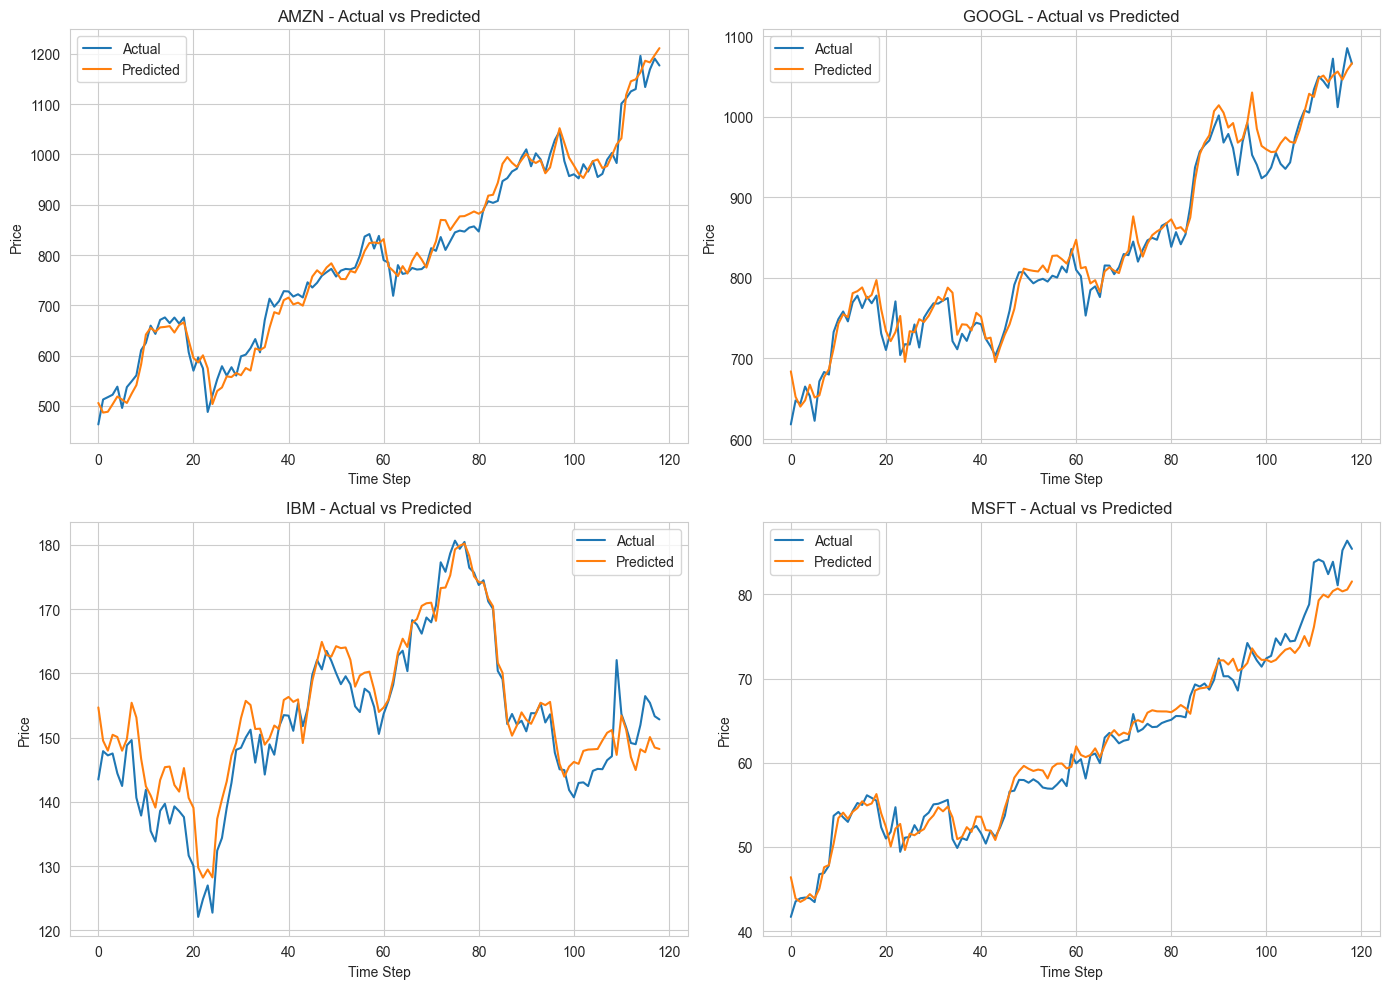

In [154]:
# Plotting the actual vs predicted values for all targets

stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
y_test_inv_mul = y_scaler_mul.inverse_transform(y_test_mul)
y_pred_inv_mul = y_scaler_mul.inverse_transform(y_pred_LSTM_mul)

plt.figure(figsize=(14, 10))

for i in range(y_test_mul.shape[1]):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test_inv_mul[:, i], label='Actual')
    plt.plot(y_pred_inv_mul[:, i], label='Predicted')
    plt.title(f'{stock_names[i]} - Actual vs Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

This project focused on predicting stock prices using Recurrent Neural Networks (RNNs), with a goal of understanding how sequential models like Simple RNN and LSTM perform on real-world financial time series data. We used historical daily stock data for four major technology companies — Amazon (AMZN), Google (GOOGL), IBM, and Microsoft (MSFT) — spanning from 2006 to 2018.

##### `Data Preparation and Processing`
We started by merging and cleaning data from four separate CSV files, handling two main data issues:
- Missing values in the "Open" and "Low" columns were imputed using linear interpolation, preserving temporal continuity.
- An extra record for IBM on a date when other stocks had no entry was removed to maintain sequence alignment, which is essential for RNNs.

The data was then transformed into a supervised learning format using a sliding window approach. Each window captured a sequence of days used to predict the next day's closing price.

##### `Modeling Approaches and Configurations`
We structured the problem in two parts:

 1. Single-Stock Prediction (IBM)
    - Window Size: 21 days (approx. 1 trading month)
    - Window Stride: 1
    - Target: Closing price of IBM

 2. Multi-Stock Prediction (AMZN, GOOGL, IBM, MSFT)
    - Window Size: 65 days (approx. 1 trading quarter)
    - Window Stride: 5
    - Target: Closing prices of all four stocks

Both Simple RNN and LSTM models were trained for each setup. We experimented with various hyperparameters (units, dropout, dense layer size, learning rate, etc.) and used early stopping for regularization.

##### `Results & Insights`

| Problem Type       | Model      | MSE      | MAE      | R² Score   |
| ------------------ | ---------- | -------- | -------- | ---------- |
| Single-stock (IBM) | Simple RNN | 0.02     | 0.11     | 0.8793     |
|                    | LSTM       | **0.01** | **0.07** | **0.9531** |
| Multi-stock (All)  | Simple RNN | 0.03     | 0.14     | 0.8787     |
|                    | LSTM       | **0.01** | **0.08** | **0.9477** |


##### `Key observations:`

- LSTM models outperformed Simple RNNs in both single and multi-stock setups.
- Even with multiple output targets, LSTM generalized well, indicating its capacity to capture inter-stock dependencies.
- The high R² scores, especially for LSTM, suggest that the models were able to explain a significant proportion of the variance in the stock prices.

##### `Conclusion and Recommendations`
The project clearly demonstrates that LSTM networks are more effective than Simple RNNs in capturing complex patterns in stock price data. For real-world applications, especially when predicting multiple stock prices simultaneously, LSTM is the more robust and scalable choice.

Going forward, the model can be further enhanced by:
- Incorporating external features such as news sentiment, market indices, or economic indicators.
- Adding technical indicators (like RSI, MACD) to enrich the input features.

This project successfully demonstrated that well-tuned RNNs — especially LSTMs — can be powerful tools for stock price prediction when supported by thorough data preparation and thoughtful temporal framing.